In [1]:
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

In [2]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [3]:
torch.cuda.is_available()

True

In [4]:
import matplotlib.pyplot as plt
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split
from keras.applications import  ResNet152V2
from keras.applications import VGG16
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, GlobalAveragePooling2D
from keras.layers import InputLayer
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [5]:
np.random.seed(42)
tf.random.set_seed(42)
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jangedoo/utkface-new")

print("Path to dataset files:", path)

100%|██████████| 331M/331M [00:02<00:00, 122MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1


# Data Proccesing

In [ ]:
!ls /root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1


crop_part1  UTKFace  utkface_aligned_cropped


Total number of images  : 23708
Sample Image path       : 40_0_1_20170113182334142.jpg.chip.jpg
Sample Age              : 40
Sample Gender           : Male



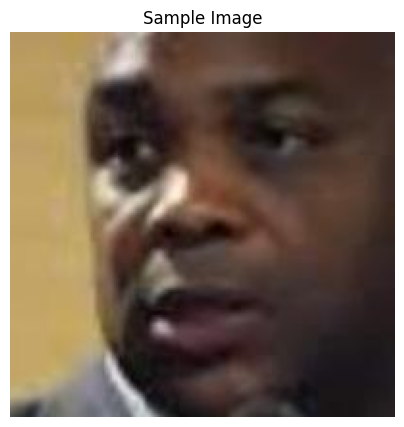

In [7]:
dir_path = "/root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/UTKFace/"
image_paths = os.listdir(dir_path)

gender_mapping = ["Male", "Female"]

rand_image_path = np.random.choice(image_paths)
rand_image = plt.imread(dir_path + rand_image_path)/255.
sample_age, sample_gender, *_ = rand_image_path.split("_")

print(f"Total number of images  : {len(image_paths)}")
print(f"Sample Image path       : {rand_image_path}")
print(f"Sample Age              : {sample_age}")
print(f"Sample Gender           : {gender_mapping[int(sample_gender)]}\n")

plt.figure(figsize = (5,5))
plt.title("Sample Image")
plt.imshow(rand_image)
plt.axis("off")
plt.show()

In [8]:
male_count = 0

ages = []

for path in image_paths:
    path_split = path.split("_")
    if "0" == path_split[1]:
        male_count += 1
    ages.append(int(path_split[0]))

female_count = len(image_paths) - male_count

pie_chart = px.pie(
    names = gender_mapping,
    values = [male_count, female_count],
    hole = 0.5,
    title = "Gender Distribution (Donut Chart)",
    height = 500
)
pie_chart.show()


It seems our dataset exhibits a slight class imbalance, with a higher count of male images compared to female ones—approximately 52% male and 48% female representation. While this imbalance isn't substantial enough to significantly impact model accuracy, it's worth noting for a comprehensive understanding of the dataset's bias towards male images. Managing this slight skew could enhance the model's robustness and fairness in predictions, even though its current impact on accuracy might be limited.

In [ ]:
fig = px.histogram(sorted(ages), title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Value Counts"
)
fig.show()


fig = px.box(x = sorted(ages), notched=True, title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",

)
fig.show()

Interestingly, these peaks exhibit distinct intensities, with the latter peak notably stronger. Specifically, we observe a peak around age 1 with approximately 1123 images, contrasting the substantial peak at 26 years with approximately 2197 images.

Notably, while our dataset does include a few images of elderly individuals aged above 80, these occurrences constitute minor peaks. Overall, this distribution indicates a potential bias towards younger age groups, underscoring the dataset's emphasis on images depicting individuals in their early years and adulthood rather than advanced age.

The insights gleaned from the box plot affirm our initial observations derived from the histogram. The data distinctly segregates into two subsets: a significant portion featuring images of very young children, corroborating the histogram's peak around age 1, and a substantial concentration of adult individuals between 26 and 45 years old.

In [9]:
np.random.shuffle(image_paths)

train_images, test_images = train_test_split(
    image_paths,
    train_size = 0.8,
    test_size = 0.2
)

train_images, valid_images = train_test_split(
    image_paths,
    train_size = 0.8,
    test_size = 0.2
)

print(f"Training Size : {len(train_images)}")
print(f"Testing Size  : {len(test_images)}")
train_ages = [int(path.split("_")[0]) for path in train_images]
train_genders = [int(path.split("_")[1]) for path in train_images]

valid_ages = [int(path.split("_")[0]) for path in valid_images]
valid_genders = [int(path.split("_")[1]) for path in valid_images]

test_ages = [int(path.split("_")[0]) for path in test_images]
test_genders = [int(path.split("_")[1]) for path in test_images]

Training Size : 18966
Testing Size  : 4742


In [10]:
def show_image(image, show=False):
    """
    Displays the provided image without axis.

    Args:
    - image (array-like): The image data to be displayed.
    - show (bool): If True, displays the image immediately. Defaults to False.

    Returns:
    - None
    """
    plt.imshow(image)
    plt.axis("off")

    if show:
        plt.show()


def preprocess_age_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    """
    Preprocesses an image for analysis by extracting age and gender from the image path,
    loading and decoding the image, resizing it to (IMAGE_SIZE,IMAGE_SIZE), normalizing pixel values,
    and returning the preprocessed image along with age and gender labels.

    Args:
    - image_path (str): The path to the image file.
    - dir_path (str): The directory path where the image is located. Defaults to `dir_path`.

    Returns:
    - tuple: A tuple containing the preprocessed image as a TensorFlow tensor,
             the age (int), and the gender (int) extracted from the image path.
    """
    # Load the Image
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)

    # Resize and Normalize the Image
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)

    return image, age

def preprocess_gender_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    """
    Preprocesses an image for analysis by extracting age and gender from the image path,
    loading and decoding the image, resizing it to (IMAGE_SIZE,IMAGE_SIZE), normalizing pixel values,
    and returning the preprocessed image along with age and gender labels.

    Args:
    - image_path (str): The path to the image file.
    - dir_path (str): The directory path where the image is located. Defaults to `dir_path`.

    Returns:
    - tuple: A tuple containing the preprocessed image as a TensorFlow tensor,
             the age (int), and the gender (int) extracted from the image path.
    """
    # Load the Image
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)

    # Resize and Normalize the Image
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)

    return image, gender

In [11]:
train_ds = tfds.Dataset.from_tensor_slices((train_images, train_ages, train_genders)).shuffle(2000)
train_age_ds = train_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
train_gender_ds = train_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

valid_ds = tfds.Dataset.from_tensor_slices((valid_images, valid_ages, valid_genders)).shuffle(2000)
valid_age_ds = valid_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
valid_gender_ds = valid_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

test_ds  = tfds.Dataset.from_tensor_slices((test_images, test_ages, test_genders)).shuffle(500)
test_age_ds = test_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
test_gender_ds = test_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

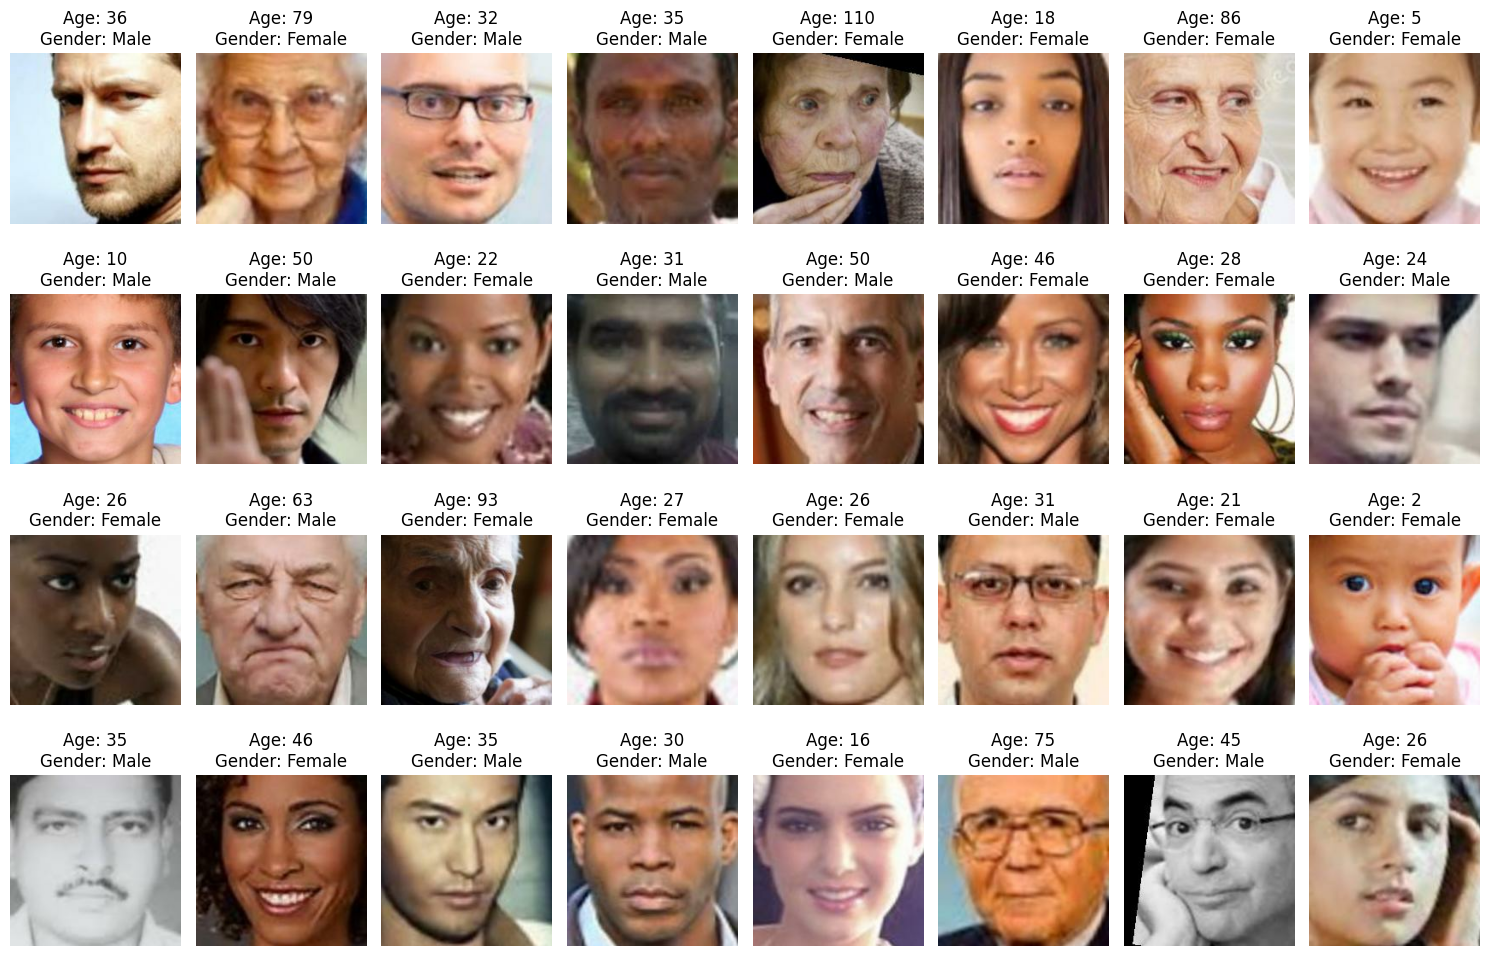

In [12]:
plt.figure(figsize=(15, 10))
for images, ages, genders in train_ds.batch(BATCH_SIZE).take(1):

    for index in range(len(images)):
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        plt.subplot(4, 8, index + 1)
        plt.imshow(image)
        plt.title(f"Age: {ages[index]}\nGender: {gender_mapping[genders[index]]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

# Age Model - VGG16

In [ ]:
vgg_16 = VGG16(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights = "imagenet")


vgg_16.trainable = False


age_net = Sequential([
    InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3), name="ImageInput"),
    vgg_16,
    Dropout(0.4, name = "SlightDroput"),
    Flatten(name="FlattenEmbeddings"),
    Dense(256, activation="relu", kernel_initializer="he_normal"),
    Dense(1, name="AgeOutput")
], name="AgeNet")


age_net.compile(
    loss = "mae",
    optimizer = 'adam',
    weighted_metrics=[]
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Check if GPU is available and set memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU(s) available and configured for TensorFlow!")
    except RuntimeError as e:
        print(f"Error setting up GPU: {e}")
else:
    print("No GPU available. Using CPU.")

age_history = age_net.fit(
    train_age_ds,
    validation_data=valid_age_ds,
    epochs=20,
    batch_size=BATCH_SIZE,
    callbacks=[
        EarlyStopping(
            patience=5,
            monitor="val_loss",
            restore_best_weights=True
        ),
        ModelCheckpoint(
            "Age-VGG16.keras",
            save_best_only=True
        )
    ]
)

Error setting up GPU: Physical devices cannot be modified after being initialized
Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 109s 177ms/step - loss: 11.1570 - val_loss: 8.1913
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 103s 174ms/step - loss: 8.1813 - val_loss: 7.4786
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 104s 175ms/step - loss: 7.6403 - val_loss: 7.1225
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 104s 175ms/step - loss: 7.2531 - val_loss: 7.0967
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 103s 174ms/step - loss: 7.0266 - val_loss: 6.9037
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 102s 172ms/step - loss: 6.8252 - val_loss: 6.9960
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 102s 172ms/step - loss: 6.8157 - val_loss: 6.9370
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 142s 172ms/step - loss: 6.6262 - val_loss: 7.2517
Epoch 9/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 103s 174ms/step - loss: 6.5494 - val_loss: 6.8116
Epoch 10/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 142s 174ms/step - loss: 6.4744 - val_loss: 6.6745
Epoch 11/20
593/

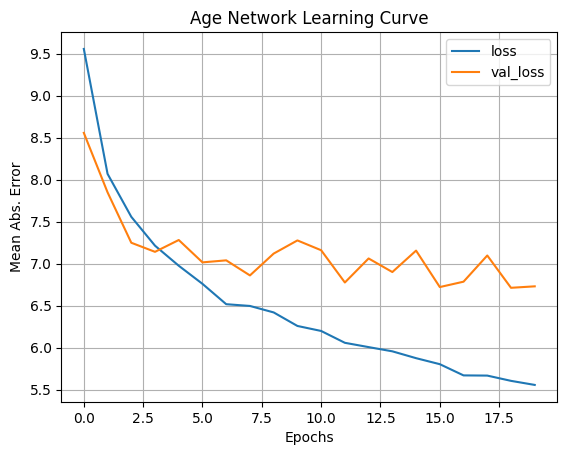

In [ ]:
age_his_df = pd.DataFrame(age_history.history)

# Visualization
age_his_df.plot()
plt.title("Age Network Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Mean Abs. Error")
plt.grid()
plt.show()

# ResNet152 - Gender Model


In [ ]:

resnet = ResNet152V2(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights="imagenet")

resnet.trainable = False


gender_net = Sequential([
    InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3), name="ImageInput"),
    resnet,
    Dropout(0.2, name = "SlightDroput"),
    GlobalAveragePooling2D(name="GlobalAvgPooling"),
    Dense(1, activation="sigmoid", name="gender")
], name="GenderNet")

gender_net.compile(
    loss = "binary_crossentropy",
    optimizer = 'adam',
    metrics = ['accuracy'],
    weighted_metrics=[]
)

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
gender_history = gender_net.fit(
    train_gender_ds,
    validation_data = valid_gender_ds,
    epochs = 20,
    batch_size = BATCH_SIZE,
    callbacks = [
        EarlyStopping(
            patience = 5,
            monitor = "val_accuracy",
            restore_best_weights = True
        ),

        ModelCheckpoint(
            "Gender-ResNet152.keras",
            save_best_only=True
        )
    ]
)

Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 190s 275ms/step - accuracy: 0.7967 - loss: 0.4375 - val_accuracy: 0.8536 - val_loss: 0.3411
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 167s 235ms/step - accuracy: 0.8500 - loss: 0.3342 - val_accuracy: 0.8532 - val_loss: 0.3354
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 156s 259ms/step - accuracy: 0.8627 - loss: 0.3140 - val_accuracy: 0.8604 - val_loss: 0.3225
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 137s 232ms/step - accuracy: 0.8646 - loss: 0.3030 - val_accuracy: 0.8577 - val_loss: 0.3291
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 139s 234ms/step - accuracy: 0.8729 - loss: 0.2967 - val_accuracy: 0.8665 - val_loss: 0.3127
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 143s 241ms/step - accuracy: 0.8734 - loss: 0.2881 - val_accuracy: 0.8676 - val_loss: 0.3087
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 158s 266ms/step - accuracy: 0.8732 - loss: 0.2873 - val_accuracy: 0.8705 - val_loss: 0.3048
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 155s 261ms/step - accuracy: 0.8802 -

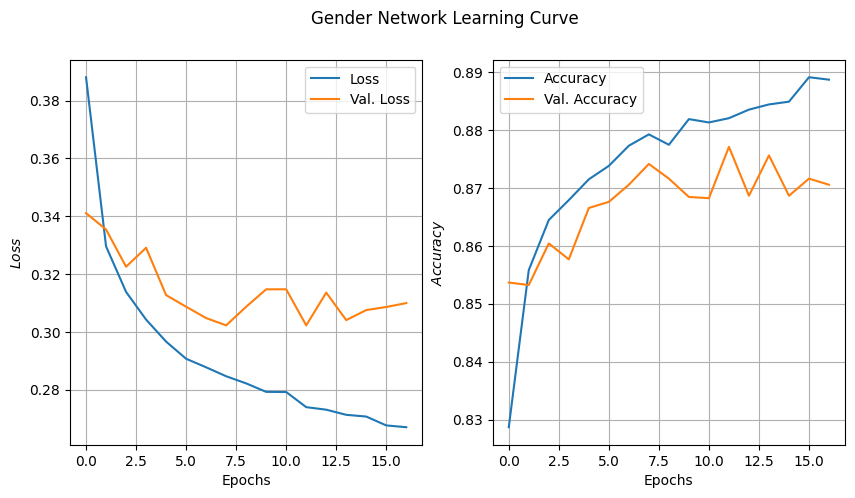

In [ ]:
gender_his_df = pd.DataFrame(gender_history.history)

# Visualization
plt.figure(figsize=(10, 5 ))
plt.subplot(1,2,1)
plt.suptitle("Gender Network Learning Curve")
plt.plot(gender_his_df['loss'], label="Loss")
plt.plot(gender_his_df['val_loss'], label="Val. Loss")
plt.xlabel("Epochs")
plt.ylabel("$Loss$")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(gender_his_df['accuracy'], label="Accuracy")
plt.plot(gender_his_df['val_accuracy'], label="Val. Accuracy")
plt.xlabel("Epochs")
plt.ylabel("$Accuracy$")
plt.grid()
plt.legend()

plt.show()

# Evaluation of Models

In [ ]:
age_net = tf.keras.models.load_model("/content/Age-VGG16.keras", compile=True)
gender_net = tf.keras.models.load_model("/content/Gender-ResNet152.keras", compile=True)

In [ ]:
age_net.evaluate(test_age_ds)
gender_net.evaluate(test_gender_ds)

149/149 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - loss: 4.7946
149/149 ━━━━━━━━━━━━━━━━━━━━ 31s 207ms/step - accuracy: 0.8986 - loss: 0.2720


[0.2655615210533142, 0.8960354328155518]

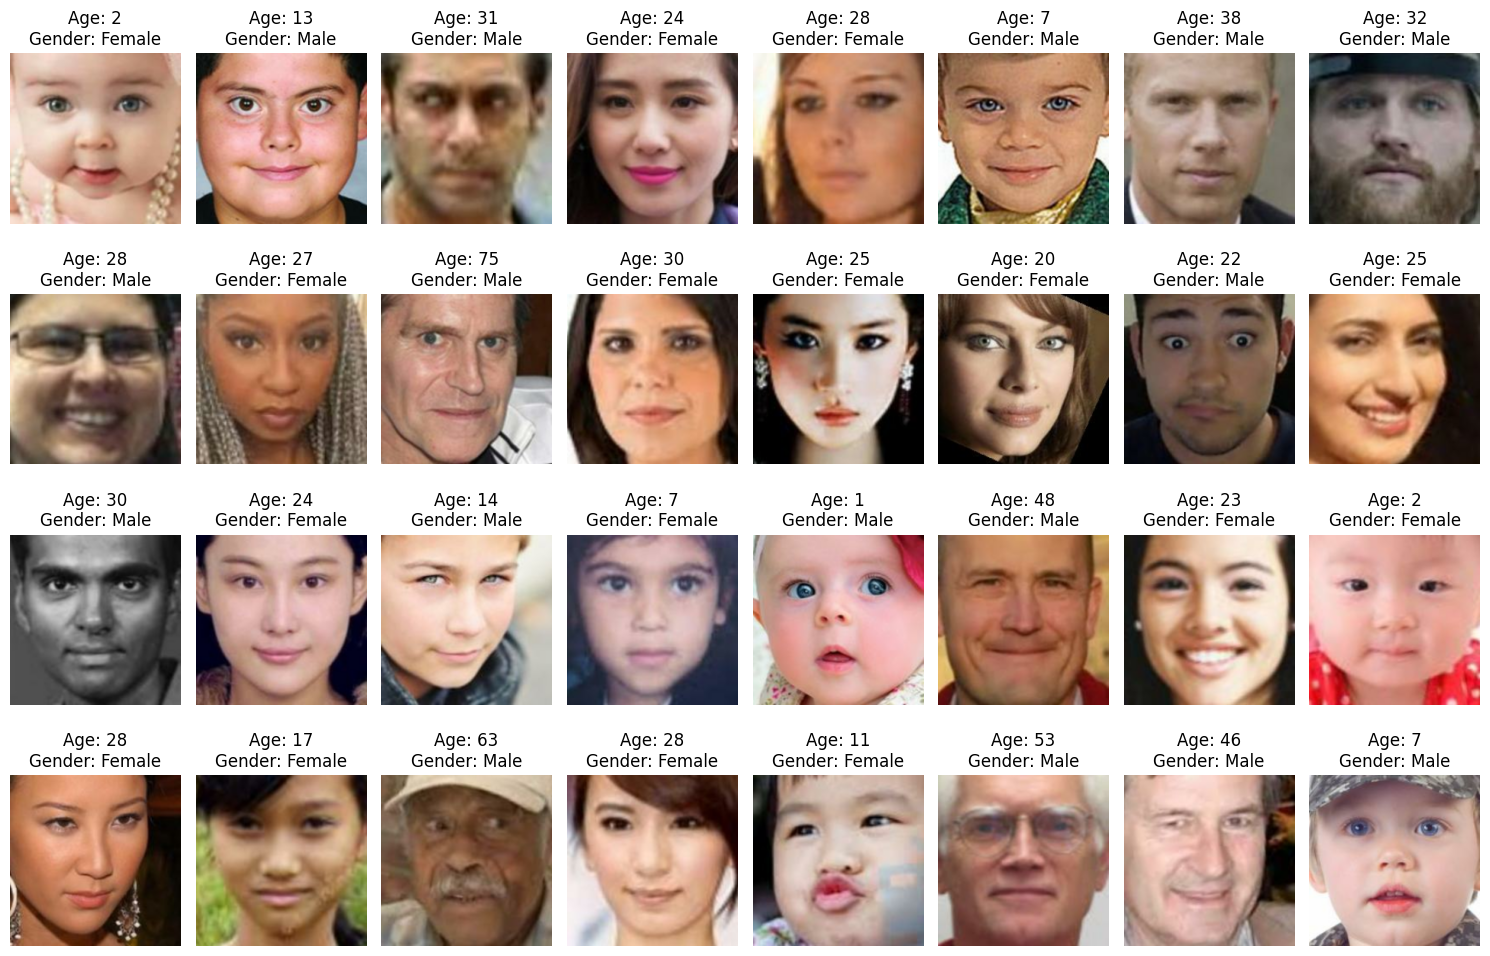

In [ ]:
plt.figure(figsize=(15, 10))
for images, ages, genders in test_ds.batch(BATCH_SIZE).take(1):
    for index in range(len(images)):

        # Image Processing
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        image = tf.cast(image, tf.float32)
        image = image/255.
        image = tf.image.resize(image, [224,224])
        image = tf.reshape(image, [-1,224,224,3])

        # Predictions
        pred_age = tf.round(tf.squeeze(age_net.predict(image, verbose=0)), 2)
        pred_gender = tf.round(tf.squeeze(gender_net.predict(image, verbose=0)))

        # Visualization
        plt.subplot(4, 8, index + 1)
        plt.imshow(image[0])
        plt.title(f"Age: {int(pred_age)}\nGender: {gender_mapping[int(pred_gender)]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

# Check on External Data

Тут мы проверили модель на сторонних фотках а точнее на фото **Кончита Вурст**


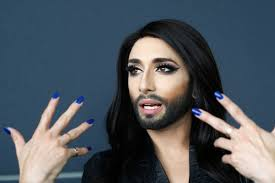

In [ ]:
from google.colab import files
uploaded = files.upload()

image_path = list(uploaded.keys())[0]

image, _ = preprocess_age_data(image_path, 0, 0, dir_path="")
image = tf.expand_dims(image, axis=0)

predicted_age = age_net.predict(image)
predicted_gender = gender_net.predict(image)

print(f"Predicted age: {predicted_age[0][0]:.0f}")
print(f"Predicted gender: {gender_mapping[int(round(predicted_gender[0][0]))]}")

Saving умкщ.jpg to умкщ.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted age: 24
Predicted gender: Male


In [ ]:
from google.colab import files
uploaded = files.upload()

image_path = list(uploaded.keys())[0]

image, _ = preprocess_age_data(image_path, 0, 0, dir_path="")
image = tf.expand_dims(image, axis=0)

predicted_age = age_net.predict(image)
predicted_gender = gender_net.predict(image)

print(f"Predicted age: {predicted_age[0][0]:.0f}")
print(f"Predicted gender: {gender_mapping[int(round(predicted_gender[0][0]))]}")

Saving programma-zdorove-rebenka-v-pervyy-god-zhizni.jpg to programma-zdorove-rebenka-v-pervyy-god-zhizni (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Predicted age: 7
Predicted gender: Male


Как мы видим у нас есть проблемы с возростом
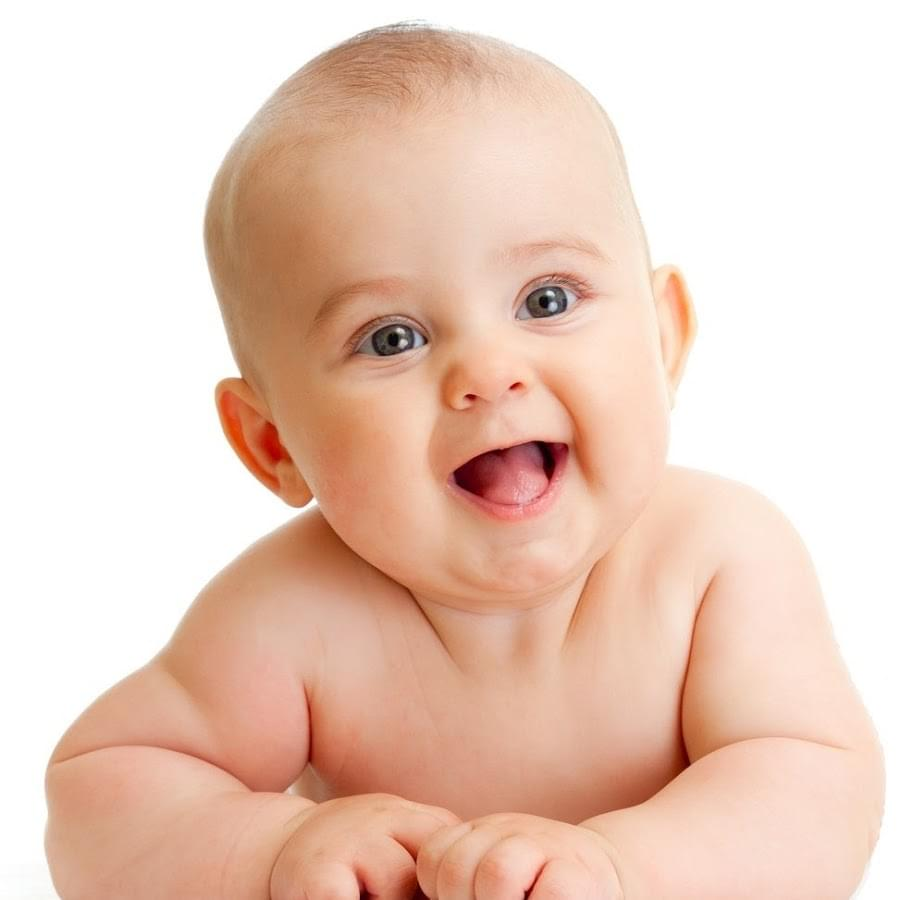

# Model Improvement
##Так как наши модели показали себя хорошо, а точнее __Gender-ResNet152__ показал хороший **Accuracy равный 89%** нами было решено не трогать его. И акцент был поставлен на модель для предсказания возроста **Age-VGG16** хоть и он показал **5% mae**.

---

⚡

In [13]:
from tensorflow.keras.layers import InputLayer, Dropout, GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Input
from tensorflow.keras.losses import Huber

vgg_16 = VGG16(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights = "imagenet")


vgg_16.trainable = False


age_net = Sequential([
    InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3), name="ImageInput"),
    vgg_16,
    Dropout(0.4, name="SlightDroput"),
    GlobalAveragePooling2D(name="GlobalPooling"),
    Dense(512, activation="relu", kernel_initializer="he_normal"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation="relu", kernel_initializer="he_normal"),
    BatchNormalization(),
    Dense(1, name="AgeOutput")
], name="AgeNet")

age_net.compile(
    loss="huber_loss",
    optimizer="adam",
    metrics=["mae"]
)

callbacks = [
    EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True),
    ModelCheckpoint("Age-VGG16-improved.keras", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1)
]

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.losses import Huber
import datetime

# GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU(s) available and memory growth configured.")
    except RuntimeError as e:
        print(f"Error setting up GPU: {e}")
else:
    print("No GPU available. Using CPU.")

# Callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    EarlyStopping(
        patience=5,
        monitor="val_loss",
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "Age-VGG16.keras",
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=3,
        verbose=1
    ),
    TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    )
]

# Compile model with Huber Loss
age_net.compile(
    loss=Huber(),
    optimizer='adam',
    weighted_metrics=[]
)

# Training the model
age_history = age_net.fit(
    train_age_ds.prefetch(buffer_size=tf.data.AUTOTUNE),
    validation_data=valid_age_ds.prefetch(buffer_size=tf.data.AUTOTUNE),
    epochs=20,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)


Error setting up GPU: Physical devices cannot be modified after being initialized
Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 134s 192ms/step - loss: 23.3823 - val_loss: 9.1811 - learning_rate: 0.0010
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 111s 166ms/step - loss: 9.9094 - val_loss: 9.8229 - learning_rate: 0.0010
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 100s 168ms/step - loss: 9.5247 - val_loss: 9.7527 - learning_rate: 0.0010
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 141s 167ms/step - loss: 9.2629 - val_loss: 8.7023 - learning_rate: 0.0010
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 143s 169ms/step - loss: 9.1954 - val_loss: 8.5443 - learning_rate: 0.0010
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 142s 169ms/step - loss: 9.1203 - val_loss: 8.5998 - learning_rate: 0.0010
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 100s 169ms/step - loss: 9.0184 - val_loss: 9.0661 - learning_rate: 0.0010
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 142s 169ms/step - loss: 8.8976 - val_loss: 8.4790 - learning_rate: 0.0010
Epoch

In [18]:
age_net_new = tf.keras.models.load_model("/content/Age-VGG16.keras", compile=True)
gender_net = tf.keras.models.load_model("/content/Gender-ResNet152.keras", compile=True)

In [16]:
age_net_new.evaluate(test_age_ds)

149/149 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - loss: 7.5115


7.501519680023193

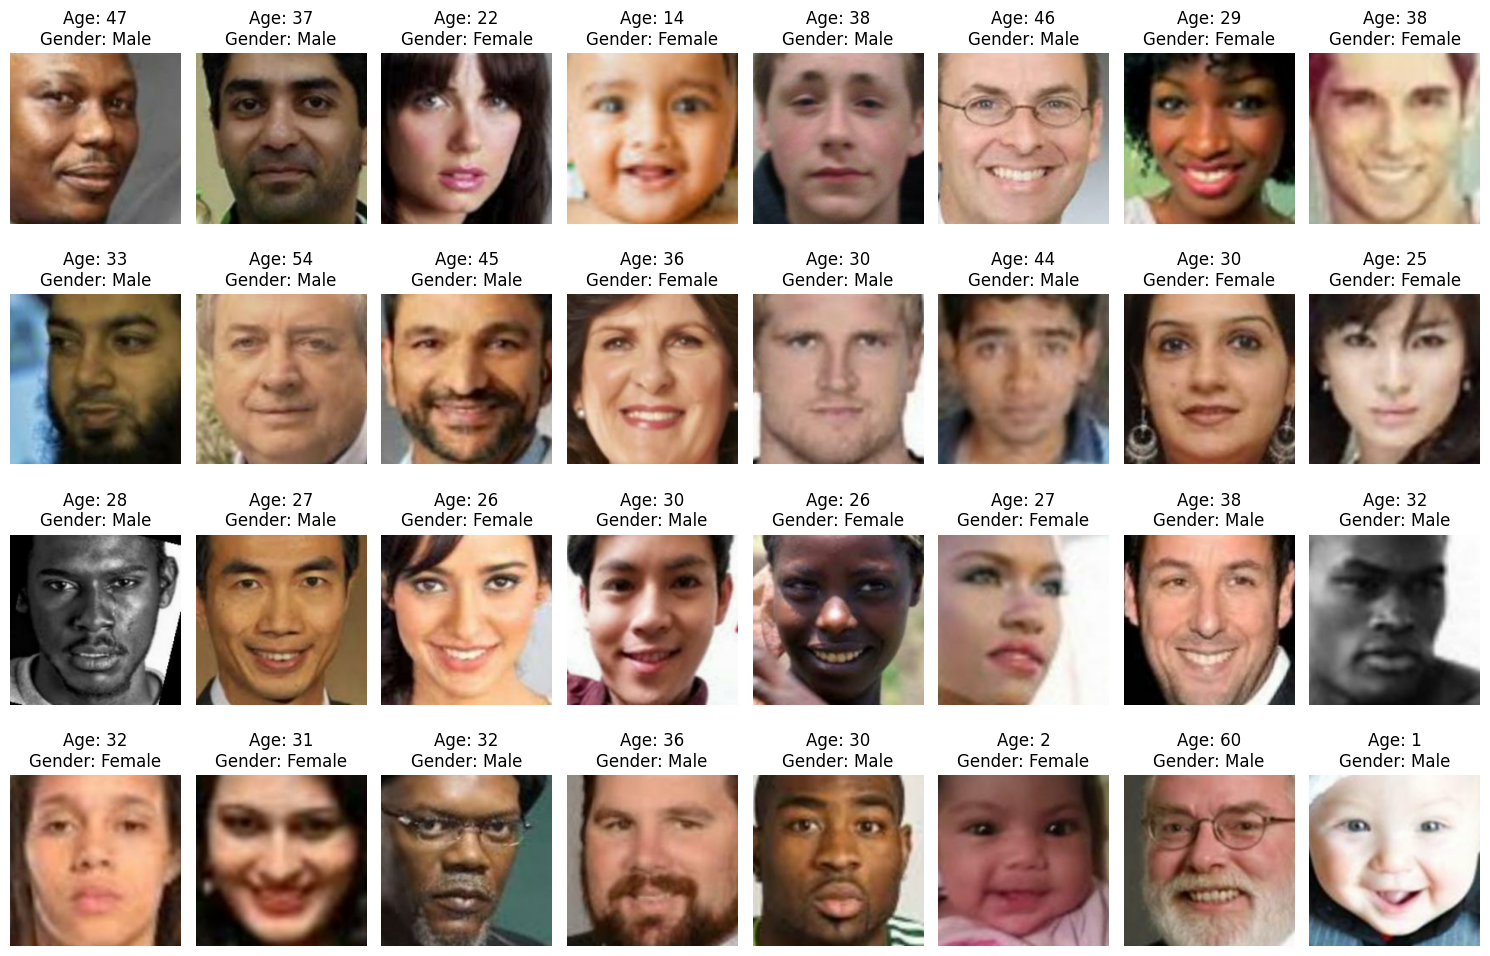

In [27]:
plt.figure(figsize=(15, 10))
for images, ages, genders in test_ds.batch(BATCH_SIZE).take(1):
    for index in range(len(images)):

        # Image Processing
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        image = tf.cast(image, tf.float32)
        image = image/255.
        image = tf.image.resize(image, [224,224])
        image = tf.reshape(image, [-1,224,224,3])

        # Predictions
        pred_age = tf.round(tf.squeeze(age_net_new.predict(image, verbose=0)), 2)
        pred_gender = tf.round(tf.squeeze(gender_net.predict(image, verbose=0)))

        # Visualization
        plt.subplot(4, 8, index + 1)
        plt.imshow(image[0])
        plt.title(f"Age: {int(pred_age)}\nGender: {gender_mapping[int(pred_gender)]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

In [30]:
# prompt: Давай подключим Стрим лит

# Assuming you have Streamlit installed
# If not, uncomment the following line and run it in your Colab environment
# !pip install streamlit

import streamlit as st
import tensorflow as tf
import matplotlib.pyplot as plt

# Load your pre-trained models
age_net_new = tf.keras.models.load_model("/content/Age-VGG16.keras", compile=True)
gender_net = tf.keras.models.load_model("/content/Gender-ResNet152.keras", compile=True)

# Define a function to process an image and make predictions
def predict_age_gender(image_path):
  """Processes an image and predicts age and gender using the loaded models."""

  # Load and pre-process the image (similar to your existing code)
  image = tf.io.read_file(image_path)
  image = tf.io.decode_jpeg(image)
  image = tf.cast(image, tf.float32)
  image = image / 255.
  image = tf.image.resize(image, [224, 224])
  image = tf.reshape(image, [-1, 224, 224, 3])

  # Make predictions
  pred_age = tf.round(tf.squeeze(age_net_new.predict(image, verbose=0)), 2)
  pred_gender = tf.round(tf.squeeze(gender_net.predict(image, verbose=0)))

  return int(pred_age), int(pred_gender)


# Streamlit UI
st.title("Age and Gender Prediction")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
  # Save the uploaded file temporarily
  with open("uploaded_image.jpg", "wb") as f:
    f.write(uploaded_file.getbuffer())

  # Make predictions
  predicted_age, predicted_gender = predict_age_gender("uploaded_image.jpg")

  # Display the image and predictions
  st.image("uploaded_image.jpg", caption="Uploaded Image", use_column_width=True)

  # Display predicted age and gender
  st.write(f"Predicted Age: {predicted_age}")
  st.write(f"Predicted Gender: {'Male' if predicted_gender == 0 else 'Female'}")

# To run this Streamlit app in Colab:
# 1. Make sure you have Streamlit installed
# 2. Save this code as a Python file (e.g., app.py)
# 3. Run the following command in a Colab cell:
# !streamlit run app.py
# 4. A link will be generated to access your app in a browser.

2024-11-19 17:47:17.065 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 17:47:17.198 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-11-19 17:47:17.201 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 17:47:17.204 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 17:47:17.206 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 17:47:17.213 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 17:47:17.216 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 17:47:17.218 Thread 'MainThread': mi

In [29]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.7 MB/s eta 0:00:00
